# 6. CRP + Hawkes process

In [1]:
# Common imports 
from ast import literal_eval

import gensim
import numpy as np
import pandas as pd
import datetime
import sys
print(sys.version)

3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]


## Load and preprocess the data

First, we need to load the data from the csv. This file contains the documents already processed and cleaned after applying the following steps:

1. Tokenization
2. Homogeneization, which includes:
    1. Removing capitalization.
    2. Removing non alphanumeric tokens (e.g. punktuation signs)
    3. Stemming/Lemmatization.
3. Cleaning
4. Vectorization


We load it as a `pandas` dataframe. 

***Note***: The timestamp column contains the time at which the event was generated in ***seconds***.


In [2]:
df = pd.read_csv('../data/tweets_cleaned.csv')
df.drop_duplicates(subset="tweet", inplace=True)

df['tokens'] = df['tokens'].apply(literal_eval) #Transform the string into a list of tokens
df.sort_values(by='timestamp', inplace=True)

### Create the dictionary

Up to this point, we have transformed the raw text collection in a list of documents stored in `X_tokens`, where each document is a collection 
of the words that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into 
a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.

In [3]:
I = 350
X_tokens = list(df['tokens'].values)
dictionary = gensim.corpora.Dictionary(X_tokens)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)

I = len(dictionary)

### Create the dataset for the HDHP

Build the dataset `X_events` as a list of events where each event is a tuple `X_events[i] = (ts, w, user_id, meta_info)` of four values:
- `ts`: timestamp of the event. It is important to choose the base time scale (e.g., days, months) and it is also recommended to normalized them so that the timestamp of the first event is 0.
- `w`: represents the content of the document. It should be a string containing the tokens separated by a white space.
- `user_id`: the id of the user that generated the event. They should go from 0 to the number of users contained in the dataset
- `meta_info`: list with extra information. It is not needed for the tutorial so it can be set to `[]`

***Exercise 2.1:***  Implement the code to build the X_event list

In [4]:
def event_from_row(row, min_ts, user_ids):
    # timestamp of the event
    # normalize
    ts = row['timestamp'] - min_ts
    # rescale to hours
    ts /= 60 * 60
    
    # content of the document
    w = " ".join(token for token in row['tokens'] if token in dictionary.values())
    
    # user_id 
    user_id = user_ids[row['user_id']]
    
    # meta_info
    meta_info = []
    
    return (ts, w, user_id, meta_info)

In [5]:
X_events = list()

min_ts = np.min(df['timestamp'])

user_ids = {}
for user in df['user_id']:
    if user in user_ids:
        continue
    
    new_id = len(user_ids)
    user_ids[user] = new_id

X_events = [ event_from_row(row, min_ts, user_ids) for _, row in df.iterrows()]
 

## Hierarchical Dirichlet Hawkes Proces (HDHP)

Import the Hierarchical Dirichlet Hawkes Proces module. Complete details about the code can be found in the official Github repository at https://github.com/Networks-Learning/hdhp.py. There, you can also find an example of how to use the package in the Jupyter notebooks under the directory examples.

***Exercise 1.1***: Find the piece of code  where the $\mu_u$ parameters are updated.  If you cannot find it, explain the reason.

**Lines 242-248:**
```python
    # opened a new table
    old_mu = self.mu_per_user[u_n]
    tables_num = tables_before + 1
    user_alive_time = t_n - self.first_observed_user_time[u_n]
    new_mu = (self.mu_rate * old_mu +
              (1 - self.mu_rate) * tables_num / user_alive_time)
    self.mu_per_user[u_n] = new_mu
```

***Exercise 1.2***: Find the piece of code where the $\alpha_l$ parameters are updated.  If you cannot find it, explain the reason.

**Lines 256-257:**
```python
    if self.update_kernels:
    self.update_time_kernel(t_n, z_n)
```

**update_time_kernel:**
```python
    def update_time_kernel(self, t_n, z_n):
        """Updates the parameter of the time kernel of the chosen pattern
        """
        v_1, v_2 = self.time_kernel_prior[z_n]
        t_last, sum_kernels, event_count, intensity, prod = self.dish_cache[z_n]
        update_value = self.kernel(t_n, t_last)
    
        sum_kernels += 1
        sum_kernels *= update_value
        prod = sum_kernels
        sum_integrals = event_count - sum_kernels
        sum_integrals /= self.omega
    
        self.time_kernel_prior[z_n] = self.alpha_0[0] + event_count - self.dish_counters[z_n], \
            self.alpha_0[1] + (sum_integrals)
    
        prior = self.time_kernel_prior[z_n]
        self.time_kernels[z_n] = self.sample_time_kernel(prior)
    
        self.dish_cache[z_n] = t_n, sum_kernels, event_count + 1, intensity, prod
```

***Exercise 1.3***:  Find the piece of code where the $\theta_l$ parameters are updated. If you cannot find it, explain the reason.

From Lecture notes 6: The $\theta_l$ are marginalized out. $\Rightarrow$ They are not updated in the code. 

***Exercise 1.4***: Find the piece of code where the $z_{1:n}$ table's assignment variables are updated.  If you cannot find it, explain the reason.

**Lines 373-399:**
```python
    if k in tables:
            # Assign to one of the already existing tables
            table = k
            dish = self.dish_on_table_per_user[u_n][table]
            # update cache for that table
            t_last, sum_kernels = self.user_table_cache[u_n][table]
            update_value = self.kernel(t_n, t_last)
            sum_kernels += 1
            sum_kernels *= update_value
            self.user_table_cache[u_n][table] = (t_n, sum_kernels)
        else:
            k = k - len(tables)
            table = len(tables)
            self.total_tables += 1
            self.total_tables_per_user[u_n] += 1
            dish = k
            # Since this is a new table, initialize the cache accordingly
            self.user_table_cache[u_n][table] = (t_n, 0)
            self.dish_on_table_per_user[u_n][table] = dish
            opened_table = True
            if dish not in self.time_kernel_prior:
                self.time_kernel_prior[dish] = self.alpha_0
                dll = self.document_log_likelihood(dn_word_counts, count_dn,
                                                   dish)
                dish_log_likelihood.append(dll)
                        
    self.table_history_with_user.append((u_n, table)) 
```

***Exercise 1.5***: Explore the code and explain how the final particle is chosen at the last iteration. Recall, we run the SMC with $|P|$ particles but at the end we only consider one sample per parameter to show the results.

**Line 901:**
```python
    final_particle_id = pick_new_particles(particles, normalized, prng)[0]
    final_particle = particles[final_particle_id]
```

**pick_new_particles:**
```python
    def pick_new_particles(old_particles, weights, prng):
        N = len(old_particles)
        index = prng.randint(N)
        beta = 0.0
        mw = max(weights)
        picked_indices = []
        for i in range(N):
            beta += prng.rand() * 2.0 * mw
            while beta > weights[index]:
                beta -= weights[index]
                index = (index + 1) % N
            picked_indices.append(index)
        return picked_indices
```

In [8]:
import hdhp

In [9]:
vocabulary = list(dictionary.values())
doc_min_length = 2
doc_length = 10
words_per_pattern = 15

alpha_0 = (2.5, 0.75)  # Parameters of the prior for the alpha, i.e,, Gamma distribution
mu_0 = (2, 0.5)  # Parameters of the prior for the mu_u, i.e, Gamma distribution
omega = 1  # Decay of the exponential  kernel, i.e., memory of the intensity.
beta = 0.01 # Concentration parameter for the Dirichlet Process

In [10]:
particle, norms = hdhp.infer(X_events, alpha_0=alpha_0, mu_0=mu_0, omega=omega, num_particles=15, beta=beta, seed=512)

Created temporary log file /home/yannic/MachineLearning/AdProbML/apmla_assignments/L6/tmp4rj3dcpo.log


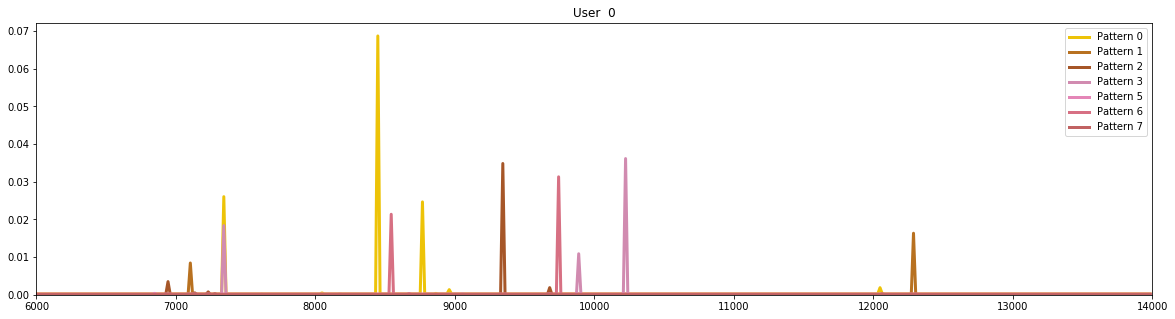

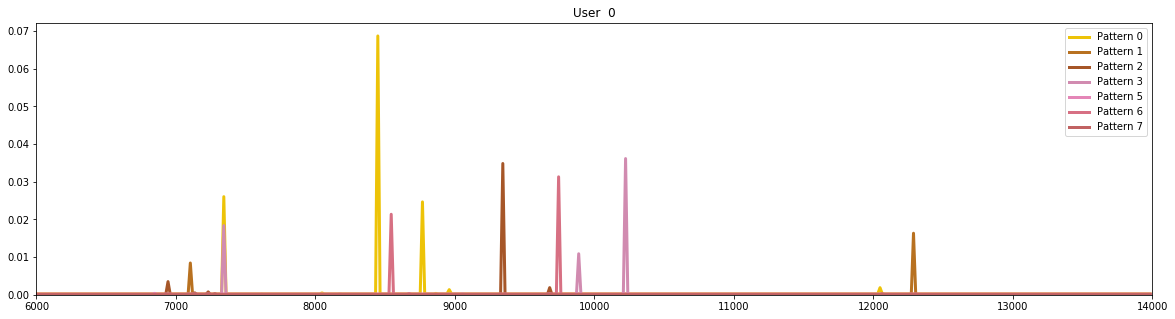

In [11]:
hdh_proc = particle.to_process(X_events)
hdh_proc.plot(paper=False, users=[0], T_min=6000, T_max=14000)

***Exercise 2.2***: Compute the log-likelihood.

In [12]:
hdh_proc = particle.to_process(X_events)

***Exercise 2.3***: From the HDHP code provided extract the necesary information about the learning patterns to fill the requested table.


In [175]:
hdh_proc = particle.to_process(X_events)

# m_l
L = hdh_proc.num_patterns
m_l = hdh_proc.dish_counters

# K
K = sum(m_l.values())

# pi_l
pi_l = [m_l[l]/K for l in range(L)]

# alpha_l
alpha_l = hdh_proc.time_kernels

# words (20 most probable)
prob_word_pattern = {}
words = {}

for l in range(L):
    word_counts_l = hdh_proc.per_pattern_word_counts[l]
    total_word_count_l = hdh_proc.per_pattern_word_count_total[l] 
    prob_word_pattern[l] = {
        word:word_counts_l[word] / total_word_count_l
        for word in word_counts_l.keys()
    }
    
    words[l] = sorted(prob_word_pattern[l], key=prob_word_pattern[l].get)[-20:]
    words[l] = list(reversed(words[l]))
    
# create data_frame
df_1 = {
    "l":np.arange(L),
    "m_l":list(m_l.values()),
    "pi_l":pi_l,
    "alpha_l":list(alpha_l.values()),
    "words":list(words.values())
}
table_1 = pd.DataFrame(df_1)

In [176]:
print("\033[1mLearning pattern table: \033[0m")
table_1

Learning pattern table: 


,l,m_l,pi_l,alpha_l,words
0,0,254,0.044734,0.069594,"[new, robot, learn, watch, end, read, like, work, talk, video, blog, win, deep, post, big, thank, help, interest, love, look]"
1,1,143,0.025185,0.104266,"[need, today, good, thank, time, day, student, use, sure, littl, cours, paper, month, hope, like, look, get, go, meet, import]"
2,2,4033,0.710285,0.391439,"[work, new, learn, like, time, research, today, peopl, great, year, look, need, help, thank, know, talk, patient, read, data, day]"
3,3,202,0.035576,0.049505,"[work, thank, happi, want, day, thing, love, better, nice, live, know, best, hous, engin, make, job, home, need, scienc, new]"
4,4,166,0.029236,0.152291,"[learn, join, head, team, health, miss, come, tomorrow, today, thank, workshop, welcom, reinforc, speak, free, excit, hear, global, session, patient]"
5,5,86,0.015146,0.127826,"[new, great, care, famili, program, call, practic, excit, articl, check, home, session, job, state, awesom, watch, collabor, need, support, today]"
6,6,86,0.015146,0.049107,"[good, work, care, thank, great, data, healthcar, import, hard, look, valu, base, improv, patient, love, confer, thing, present, tri, increas]"
7,7,55,0.009687,0.198266,"[hope, recommend, fact, book, need, stori, session, thank, use, word, follow, woman, import, got, studi, high, googl, neural, latest, power]"
8,8,144,0.025361,0.122230,"[like, data, model, look, come, method, result, day, way, base, scienc, search, set, life, differ, need, caus, make, health, think]"
9,9,16,0.002818,0.045898,"[connect, want, communiti, say, human, creat, think, miss, watch, sure, doctor, home, medic, follow, futur, today, stand, market, remind, differ]"


***Exercise 2.4***:  From the HDHP code provided extract the necesary information about the users to fill the requested table.

In [177]:
hdh_proc = particle.to_process(X_events)

num_users = hdh_proc.num_users

# number of tasks
table_hist_per_user = hdh_proc.table_history_per_user.values() 
n_tasks = [len(set(table_hist)) for table_hist in table_hist_per_user]
    
# mu_u
mu = hdh_proc.mu_per_user

# patterns
patterns = [hdh_proc.user_patterns(user) for user in range(num_users)]

# number of patterns
n_patterns_user = [len(pattern) for pattern in patterns]

# {pi_l}
pi_u_l = []
table_to_dish_per_user = hdh_proc.dish_on_table_per_user
for u, table_to_dish in enumerate(table_to_dish_per_user.values()):
    user_dishes, dish_counts = np.unique(list(table_to_dish.values()), return_counts=True)
    pi_u_l.append({l:dish_counts[i]/n_tasks[u] for i, l in enumerate(user_dishes)})

# create data_frame
df_2 = {
    "u":np.arange(num_users),
    "# of tasks":n_tasks,
    "mu_u":list(mu.values()),
    "# of patterns":n_patterns_user,
    "patterns":patterns,
    "{pi_ul}":pi_u_l
}
table_2 = pd.DataFrame(df_2)

In [178]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 81)
table_2

,u,# of tasks,mu_u,# of patterns,patterns,{pi_ul}
0,0,81,0.002696,9,"[0, 1, 2, 3, 4, 5, 6, 7, 12]","{0: 0.2962962962962963, 1: 0.13580246913580246, 2: 0.20987654320987653, 3: 0.2345679012345679, 4: 0.012345679012345678, 5: 0.012345679012345678, 6: 0.07407407407407407, 7: 0.012345679012345678, 12: 0.012345679012345678}"
1,1,103,0.002669,12,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 16, 28]","{0: 0.02912621359223301, 1: 0.07766990291262135, 2: 0.14563106796116504, 3: 0.05825242718446602, 4: 0.27184466019417475, 5: 0.22330097087378642, 6: 0.11650485436893204, 7: 0.019417475728155338, 8: 0.02912621359223301, 10: 0.009708737864077669, 16: 0.009708737864077669, 28: 0.009708737864077669}"
2,2,63,0.002146,14,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 14, 16, 18, 24, 26]","{0: 0.031746031746031744, 1: 0.015873015873015872, 2: 0.5873015873015873, 3: 0.031746031746031744, 4: 0.031746031746031744, 5: 0.031746031746031744, 6: 0.015873015873015872, 7: 0.031746031746031744, 8: 0.09523809523809523, 14: 0.047619047619047616, 16: 0.031746031746031744, 18: 0.015873015873015872, 24: 0.015873015873015872, 26: 0.015873015873015872}"
3,3,53,0.001896,8,"[1, 2, 3, 4, 8, 10, 17, 22]","{1: 0.018867924528301886, 2: 0.8490566037735849, 3: 0.03773584905660377, 4: 0.018867924528301886, 8: 0.018867924528301886, 10: 0.018867924528301886, 17: 0.018867924528301886, 22: 0.018867924528301886}"
4,4,94,0.003449,12,"[0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 16, 28]","{0: 0.0425531914893617, 1: 0.02127659574468085, 2: 0.7872340425531915, 3: 0.031914893617021274, 4: 0.010638297872340425, 5: 0.010638297872340425, 8: 0.031914893617021274, 9: 0.02127659574468085, 11: 0.010638297872340425, 12: 0.010638297872340425, 16: 0.010638297872340425, 28: 0.010638297872340425}"
5,5,75,0.002884,16,"[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18]","{0: 0.06666666666666667, 1: 0.09333333333333334, 2: 0.30666666666666664, 3: 0.10666666666666667, 5: 0.02666666666666667, 6: 0.04, 7: 0.05333333333333334, 8: 0.06666666666666667, 9: 0.04, 10: 0.06666666666666667, 11: 0.02666666666666667, 12: 0.02666666666666667, 13: 0.04, 16: 0.013333333333333334, 17: 0.013333333333333334, 18: 0.013333333333333334}"
6,6,147,0.005775,19,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 19, 22, 24, 29]","{0: 0.05442176870748299, 1: 0.08843537414965986, 2: 0.3401360544217687, 3: 0.061224489795918366, 4: 0.061224489795918366, 5: 0.02040816326530612, 6: 0.061224489795918366, 7: 0.027210884353741496, 8: 0.08843537414965986, 9: 0.006802721088435374, 10: 0.047619047619047616, 11: 0.027210884353741496, 12: 0.034013605442176874, 13: 0.013605442176870748, 14: 0.027210884353741496, 19: 0.013605442176870748, 22: 0.013605442176870748, 24: 0.006802721088435374, 29: 0.006802721088435374}"
7,7,107,0.004684,18,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21]","{0: 0.06542056074766354, 1: 0.07476635514018691, 2: 0.19626168224299065, 3: 0.11214953271028037, 4: 0.07476635514018691, 5: 0.06542056074766354, 6: 0.018691588785046728, 7: 0.09345794392523364, 8: 0.12149532710280374, 9: 0.028037383177570093, 10: 0.028037383177570093, 11: 0.009345794392523364, 12: 0.018691588785046728, 13: 0.04672897196261682, 15: 0.009345794392523364, 16: 0.018691588785046728, 20: 0.009345794392523364, 21: 0.009345794392523364}"
8,8,169,0.008014,21,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 30]","{0: 0.15976331360946747, 1: 0.08284023668639054, 2: 0.22485207100591717, 3: 0.14201183431952663, 4: 0.08284023668639054, 5: 0.04142011834319527, 6: 0.029585798816568046, 7: 0.01775147928994083, 8: 0.047337278106508875, 10: 0.005917159763313609, 11: 0.005917159763313609, 12: 0.023668639053254437, 13: 0.029585798816568046, 14: 0.029585798816568046, 15: 0.01775147928994083, 16: 0.005917159763313609, 18: 0.005917159763313609, 19: 0.01775147928994083, 22: 0.01775147928994083, 23: 0.005917159763313609, 30: 0.005917159763313609}"
9,9,121,0.012734,22,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 22, 24, 25, 30]","{0: 0.082644628